In [1]:
import re
import glob
import os
import json

models = ["Seq2Seq", "Seq2Point"]


def read_data(file_path):
    with open(file_path, "r") as file:
        data = file.read()

    # Extracting data blocks where metrics are defined, separated by markers
    models_pattern = "\s+".join(models)
    pattern = rf"\.+\s+([A-Za-z0-9]+)\s+\.+\s+(?:{models_pattern})\n"
    data_blocks = re.split(pattern, data)[1:]  # Skip the first empty block

    # Dictionary to store structured data
    structured_data = {}

    # Process blocks in pairs
    for i in range(0, len(data_blocks), 2):
        metric = data_blocks[i].strip()
        data = data_blocks[i + 1].strip()
        metric_data = {}

        lines = data.split("\n")
        for line in lines:
            line = line.strip()
            if line:  # Ensure line is not empty
                parts = re.split(
                    r"\s{2,}", line
                )  # Split on whitespace, assuming at least two spaces
                if (
                    len(parts) >= len(models) + 1
                ):  # Ensure there are enough parts for the appliance name and all model values
                    appliance = parts[0]
                    metric_data[appliance] = {}
                    for j, model in enumerate(models):
                        metric_data[appliance][model] = float(parts[j + 1])

        structured_data[metric] = metric_data

    return structured_data


def import_all_data(directory):
    # Regex pattern to extract sample rate and sequence length from filenames
    file_pattern = re.compile(r"(\d+)sec_(\d+)SL\.txt")

    all_data = {}
    for file_path in glob.glob(f"{directory}/*sec_*SL.txt"):
        match = file_pattern.search(file_path)
        if match:
            sample_rate = match.group(1)
            sequence_length = match.group(2)
            if sample_rate not in all_data:
                all_data[sample_rate] = {}
            if sequence_length not in all_data[sample_rate]:
                all_data[sample_rate][sequence_length] = {}

            # Read data for each file and store in structured dictionary
            all_data[sample_rate][sequence_length] = read_data(file_path)

    return all_data


# current directory
directory = os.getcwd()
data = import_all_data(directory)


def export_data_as_json(data, filename):
    # Get the current working directory
    directory = os.getcwd()
    filepath = os.path.join(directory, filename)

    # Convert dictionary to JSON string
    json_string = json.dumps(data, indent=4)  # `indent=4` for pretty printing

    # Write JSON string to a file
    with open(filepath, "w") as file:
        file.write(json_string)
    print(f"Data has been written to {filepath}")


export_data_as_json(data, "results.json")

Data has been written to c:\Users\Mark\Desktop\MCS6 Repo\FIT3162_MCS6_NILM\results\results.json


In [2]:
import pandas as pd

# Flatten the dictionary into a list of rows
rows = []
for sample_rate, sequences in data.items():
    for seq_len, metrics in sequences.items():
        for metric, appliances in metrics.items():
            for appliance, models in appliances.items():
                for model, value in models.items():
                    rows.append({
                        'Sample Rate': sample_rate,
                        'Sequence Length': seq_len,
                        'Metric': metric,
                        'Appliance': appliance,
                        'Model': model,
                        'Value': value
                    })

# Convert list of rows into a DataFrame
df = pd.DataFrame(rows)
df.head()


,Sample Rate,Sequence Length,Metric,Appliance,Model,Value
0,1,199,mae,fridge,Seq2Seq,31.569170
1,1,199,mae,fridge,Seq2Point,33.730221
2,1,199,mae,air conditioner,Seq2Seq,146.561981
3,1,199,mae,air conditioner,Seq2Point,150.929260
4,1,199,mae,washing machine,Seq2Seq,21.400229


In [3]:
# Set appropriate data types
df['Sample Rate'] = df['Sample Rate'].astype(int)
df['Sequence Length'] = df['Sequence Length'].astype(int)
df['Value'] = df['Value'].astype(float)

# Pivot the DataFrame to have models as columns
df = df.pivot_table(index=['Sample Rate', 'Sequence Length', 'Metric', 'Appliance'],
                          columns='Model',
                          values='Value')

df.reset_index(inplace=True)

df.to_csv("results.csv", index=False)
df.head()

Model,Sample Rate,Sequence Length,Metric,Appliance,Seq2Point,Seq2Seq
0,1,99,f1score,air conditioner,0.000000,0.000000
1,1,99,f1score,electric water heating appliance,0.089949,0.109110
2,1,99,f1score,fridge,0.107429,0.081052
3,1,99,f1score,kettle,0.164545,0.129250
4,1,99,f1score,oven,0.072977,0.122743


In [4]:
def get_max_score(group):
    results = []
    # Process each model
    for model in ['Seq2Seq', 'Seq2Point']:
        max_row = group.loc[group[model].idxmax()]
        f1_score = round(max_row[model], 3)  # Round the value to 3 decimal places
        model_name = f"{max_row['Sample Rate']}-{max_row['Sequence Length']}"
        if f1_score > 0:
            results.append({'Model': model, 'Test': model_name, 'F1 Score': f1_score})
        else:
            results.append({'Model': model, 'Test': 'N/A', 'F1 Score': 'N/A'})
    
    return pd.DataFrame(results)

# Filter the DataFrame to only include the 'f1score' metric
df_f1 = df[df['Metric'] == 'f1score']

# Apply the function to each group and concatenate the results
result_df = df_f1.groupby('Appliance').apply(get_max_score).reset_index()
result_df.drop('level_1', axis=1, inplace=True)  # Remove unnecessary index column added by groupby

# Set the new index and columns
result_df.set_index(['Appliance', 'Model'], inplace=True)
result_df = result_df.unstack('Model')
result_df.columns = result_df.columns.swaplevel(0, 1)  # Swap levels to get 'Metric' as the top level

# Reorder the columns so that 'Test' comes before 'F1 Score'
result_df.sort_index(axis=1, level='Model', inplace=True, sort_remaining=False)

result_df


Model                            Seq2Point          Seq2Seq         
                                      Test F1 Score    Test F1 Score
Appliance                                                           
air conditioner                        N/A      N/A     N/A      N/A
electric water heating appliance     3-599    0.172   6-199    0.211
fridge                              30-599    0.207    3-99    0.179
kettle                                3-99    0.195  30-599    0.369
oven                                 30-99    0.169   6-599    0.208
tumble dryer                         1-599    0.683    1-99     0.75
vacuum cleaner                       1-599    0.254   6-599     0.23
washing machine                      6-599    0.404   6-199    0.415

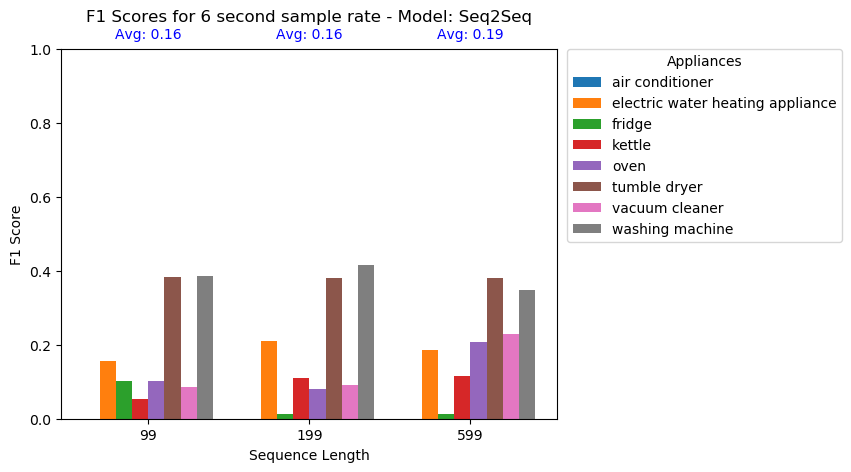

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Choose sample rate and model to display
sample_rate = "6"
model = "Seq2Seq"

# Extracting and sorting data for plotting
sorted_sequence_lengths = sorted(
    data[sample_rate].keys(), key=int
)  # Sort sequence lengths
appliances = set()

for seq_len in sorted_sequence_lengths:
    appliances.update(data[sample_rate][seq_len]["f1score"].keys())

sorted_appliances = sorted(appliances)  # Sort appliances alphabetically

# Prepare plot data
plot_data = {}
for seq_len in sorted_sequence_lengths:
    plot_data[seq_len] = {}
    for appliance in sorted_appliances:
        # Accessing model-specific F1 score
        appliance_scores = data[sample_rate][seq_len]["f1score"].get(appliance, {})
        model_score = appliance_scores.get(model, 0)  # Default to 0 if model not found
        plot_data[seq_len][appliance] = model_score

# Calculate average scores for each sequence length
average_scores = {}
for seq_len, appliances_scores in plot_data.items():
    total = 0
    count = 0
    for score in appliances_scores.values():
        if score is not None:  # Ensure that only valid scores are included
            total += score
            count += 1
    average_scores[seq_len] = total / count if count != 0 else 0

# Define the x-axis labels and the width of each bar
labels = sorted_sequence_lengths
bar_width = 0.1
num_appliances = len(sorted_appliances)
total_width = num_appliances * bar_width

# Create a numpy array of the x-axis positions for each group of bars
x_pos = np.arange(len(labels))

# Create a figure and axis object
fig, ax = plt.subplots()

# Loop through each appliance and create a set of bars for each group
for i, appliance in enumerate(sorted_appliances):
    values = [plot_data[seq][appliance] for seq in sorted_sequence_lengths]
    pos = x_pos - (total_width / 2) + (i * bar_width) + (bar_width / 2)
    ax.bar(pos, values, width=bar_width, label=appliance)

# Add average scores as text directly above the bar groups
for i, seq_len in enumerate(labels):
    ax.text(
        x_pos[i],
        1.02,
        f"Avg: {average_scores[seq_len]:.2f}",
        ha="center",
        va="bottom",
        color="blue",
        fontsize=10,
    )

# Set the x-axis labels and tick positions to be centered under each group
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)

# Add a legend to the plot
ax.legend(
    title="Appliances", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0
)

# Add axis labels and a title to the plot
ax.set_xlabel("Sequence Length")
ax.set_ylabel("F1 Score")
ax.set_title(f"F1 Scores for {sample_rate} second sample rate - Model: {model}", pad=20)

ax.set_ylim(0, 1)  # Set the y-axis limit

# Show the plot
plt.show()
